# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
device

'cuda'

In [3]:
# !wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [4]:
df = pd.read_csv('data.txt.zip', header=None)
df.head(6)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
5,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [6]:
from sklearn.preprocessing import StandardScaler

# Скалирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
def set_random_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [8]:
set_random_seed(123)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

# Ridge model
# Не стану подбирать гиперпараметр alpha

model = Ridge()
rmse_for_model = root_mean_squared_error

model.fit(X_train_scaled, y_train)
train_score = rmse_for_model(y_train, model.predict(X_train_scaled))
test_score = rmse_for_model(y_test, model.predict(X_test_scaled))
print(f"{train_score=}")
print(f"{test_score=}")

train_score=9.552822967970322
test_score=9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
# Average constant model test

average = np.mean(y_train)

best_rmse_metric_train = rmse_for_model(y_train, np.full_like(y_train, average))
best_rmse_metric_test = rmse_for_model(y_test, np.full_like(y_test, average))
print(f"{best_rmse_metric_train=}")
print(f"{best_rmse_metric_test=}")

best_rmse_metric_train=10.946566221164124
best_rmse_metric_test=10.863228020678134


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
learning_rate = 0.05
epoch = 100  # возьму 100, а не 10, чтобы качественно обучить и сравнить с прошлыми заданиями

# init
w = torch.rand(X_train.shape[1], requires_grad=True)  # weight
b = torch.rand(1, requires_grad=True)  # bias

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)  # data
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # target

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)  # data
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # target

losses_train, losses_test = [], []

for e in tqdm(range(epoch)):
    # pred
    y_pred = torch.matmul(X_train_tensor, w) + b
    loss = torch.mean((y_pred - y_train_tensor) ** 2)
    loss.backward()

    # Validation
    with torch.no_grad():
        losses_train.append(torch.sqrt(loss).item())  # RMSE
        y_pred_test = torch.matmul(X_test_tensor, w) + b
        losses_test.append(torch.sqrt(torch.mean((y_pred_test - y_test_tensor) ** 2)).item())  # RMSE

        # step
        w.data -= learning_rate * w.grad
        b.data -= learning_rate * b.grad

    # zero grad
    w.grad.data.zero_()
    b.grad.data.zero_()

    print(f"epoch {e + 1}, train {losses_train[-1]}, test {losses_test[-1]}")
# Результаты почти как в sklearn, не хватило только немного регуляризации

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1, train 1998.3157958984375, test 1998.3358154296875
epoch 2, train 1798.4808349609375, test 1798.612060546875
epoch 3, train 1618.637451171875, test 1618.7406005859375
epoch 4, train 1456.779541015625, test 1456.8695068359375
epoch 5, train 1311.1082763671875, test 1311.189208984375
epoch 6, train 1180.0050048828125, test 1180.0797119140625
epoch 7, train 1062.01318359375, test 1062.0826416015625
epoch 8, train 955.8214111328125, test 955.8869018554688
epoch 9, train 860.2498779296875, test 860.3120727539062
epoch 10, train 774.2367553710938, test 774.2962036132812
epoch 11, train 696.8263549804688, test 696.8833618164062
epoch 12, train 627.1583862304688, test 627.2132568359375
epoch 13, train 564.4588012695312, test 564.5118408203125
epoch 14, train 508.03094482421875, test 508.08221435546875
epoch 15, train 457.247802734375, test 457.2974548339844
epoch 16, train 411.5451354980469, test 411.5932922363281
epoch 17, train 370.4151916503906, test 370.4618835449219
epoch 18, trai

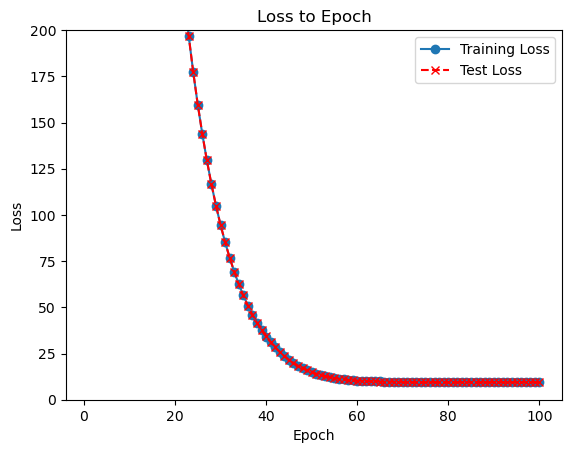

In [12]:
# visualization
plt.plot(range(1, len(losses_train) + 1), losses_train, label='Training Loss', marker='o', linestyle='-')
plt.plot(range(1, len(losses_test) + 1), losses_test, label='Test Loss', color='red', marker='x', linestyle='--')

# labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss to Epoch')

plt.legend()
plt.ylim(0, 200)

# Displaying the plot
plt.show()

# Модель хорошо обучилась. 
# Тестовая валидация видимо накладывается на лосс тренировочной выборки из за похожести данных между собой и большого количества данных (я всё проверил много-много раз и вроде так и должны быть. Но я всё ещё не уверен...)

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [13]:
from sklearn.preprocessing import StandardScaler

# Скалирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_target = StandardScaler()
y_train_scaled = scaler_target.fit_transform(
    y_train.reshape(-1, 1))  # Скалирую таргет! Без этого всё работает плохо (потом буду инвертировать скалирование)
# тестовые данные не будут скалировать, чтобы скалировать уже в самой модели 

In [14]:
# Create datasets
train_dataset_with_target = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train_scaled, dtype=torch.float32)
)

test_dataset_with_target = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)
)

# Create dataloaders
train_dataloader_target = DataLoader(train_dataset_with_target, batch_size=256, num_workers=2, persistent_workers=True)
test_dataloader_target = DataLoader(test_dataset_with_target, batch_size=1024, num_workers=2, persistent_workers=True)

In [15]:
class DefaultNet(torch.nn.Module):
    '''
    Абстрактная модель, от которой я наследую все следующие модели
    На самом деле от неё мала смысла, так как я почти ничего из этого не использую
    В классификаторе я тоже использовал эту модель, не смотря на поля rmse, 
    поскольку они и в регрессионной модели не использовались, а менять что-то уже страшно
    '''
    def __init__(self):
        super().__init__()
        self.loss_func = torch.nn.MSELoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()
        self.rmse = torch.Tensor()

    def _forward(self, x: torch.tensor) -> torch.tensor:
        pass

    def forward(self, x: torch.tensor, target=None) -> torch.tensor:
        output = self._forward(x)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            if target.dim() == 1:
                target = target.unsqueeze(1)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            self.preds = torch.cat((self.preds, output.cpu()), 0)
            self.rmse = torch.sqrt(self.loss_func(self.preds, self.targets))

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.get_accuracy

In [16]:
class Net2(DefaultNet):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.SiLU()
        self.dropout = torch.nn.Dropout(p=0.5)

        self.batch_norm0 = torch.nn.BatchNorm1d(90)
        self.linear1 = torch.nn.Linear(in_features=90, out_features=512)
        self.batch_norm1 = torch.nn.BatchNorm1d(512)
        self.linear2 = torch.nn.Linear(in_features=512, out_features=1024)
        self.batch_norm2 = torch.nn.BatchNorm1d(1024)
        self.linear3 = torch.nn.Linear(in_features=1024, out_features=512)
        self.batch_norm3 = torch.nn.BatchNorm1d(512)
        self.linear4 = torch.nn.Linear(in_features=512, out_features=256)
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        self.linear5 = torch.nn.Linear(in_features=256, out_features=128)
        self.batch_norm5 = torch.nn.BatchNorm1d(128)
        self.linear6 = torch.nn.Linear(in_features=128, out_features=64)
        self.batch_norm6 = torch.nn.BatchNorm1d(64)
        self.output = torch.nn.Linear(in_features=64, out_features=1)

    def _forward(self, x):
        x = self.batch_norm0(x)
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear4(x)
        x = self.batch_norm4(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear5(x)
        x = self.batch_norm5(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear6(x)
        x = self.batch_norm6(x)
        x = self.activation(x)
        x = self.dropout(x)

        return self.output(x)

In [17]:
def plot_history(train_history, val_history, title="loss"):
    '''
    функция для создания графика
    '''
    plt.figure(figsize=(10, 5))

    steps = np.linspace(0, len(train_history) - 1, len(val_history)).astype(int)

    plt.plot(train_history, label='Train')
    plt.scatter(steps, val_history, marker="+", s=180, c="orange", label="Val", zorder=2)
    plt.xlabel("Training steps")
    plt.ylabel(title)
    plt.legend(loc="best")
    plt.title(f"Training and Validation {title}")
    plt.show()

In [18]:
def inversed_rmse(y_pred, target, scaler):
    '''
    Функция для инвертирования отскалированного таргета
    '''
    predictions_inv = scaler.inverse_transform(y_pred.cpu().detach().numpy().reshape(-1, 1))
    predictions_inv = torch.tensor(predictions_inv, dtype=torch.float32, device=device).squeeze()
    mse = torch.nn.functional.mse_loss(predictions_inv, target.squeeze().to(device))
    return torch.sqrt(mse).item()


In [19]:

def train(model, n_epochs, optimizer, criterion, train_loader, test_loader, attempt="1", device=device):
    """
    fit
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    train_loss_log, val_loss_log = [], [float("+inf")]

    for epoch in range(n_epochs):
        # тренировка
        model.train()
        for x, target in tqdm(
                train_loader, desc=f"Training, epoch {epoch}", leave=False
        ):
            optimizer.zero_grad()
            x, target = x.to(device), target.to(device).squeeze()

            y_pred = model(x).to(device).squeeze()
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # scheduler.step()

        # валидация
        model.eval()
        with torch.no_grad():

            # train с инвертированием
            y_pred = model(torch.Tensor(train_dataloader_target.dataset.tensors[0]).to(device))
            predictions_inv = scaler_target.inverse_transform(y_pred.cpu().numpy().reshape(-1, 1))
            predictions_inv = torch.tensor(predictions_inv, dtype=torch.float32, device=device).squeeze()

            target_inv = scaler_target.inverse_transform(
                torch.Tensor(train_dataloader_target.dataset.tensors[1]).to(device).squeeze().cpu().numpy().reshape(-1,
                                                                                                                    1))
            target_inv = torch.tensor(target_inv, dtype=torch.float32, device=device).squeeze()

            rmse = torch.sqrt(torch.nn.functional.mse_loss(predictions_inv, target_inv)).item()
            train_loss_log.append(rmse)

            # val с инвертированием
            y_pred = model(torch.Tensor(test_dataloader_target.dataset.tensors[0]).to(device))
            rmse = inversed_rmse(y_pred, torch.Tensor(test_dataloader_target.dataset.tensors[1]).to(device),
                                 scaler_target)
            if rmse < min(val_loss_log):  # save best weights
                torch.save(model.state_dict(), "best_weights" + attempt)
            val_loss_log.append(rmse)

        clear_output(wait=True)
        plot_history(train_loss_log, val_loss_log, "loss")

        print("Train rmse:", train_loss_log[-1])
        print("Val rmse:", val_loss_log[-1])
        print("best val rmse:", min(val_loss_log))



In [20]:
def test(model, criterion, test_loader) -> torch.Tensor:
    """
    inference for regression and classification
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn - а зачем?
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    predicts = []

    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs.to(device))
            predicts.append(outputs)

    predicts = torch.cat(predicts, dim=0)

    return predicts

In [21]:
EPOCHS = 200
LR = 0.001

In [22]:
# from torch.optim.lr_scheduler import StepLR
set_random_seed(123)
model3 = Net2().to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=LR)
# scheduler = StepLR(optimizer, step_size=5)
criterion = torch.nn.MSELoss()


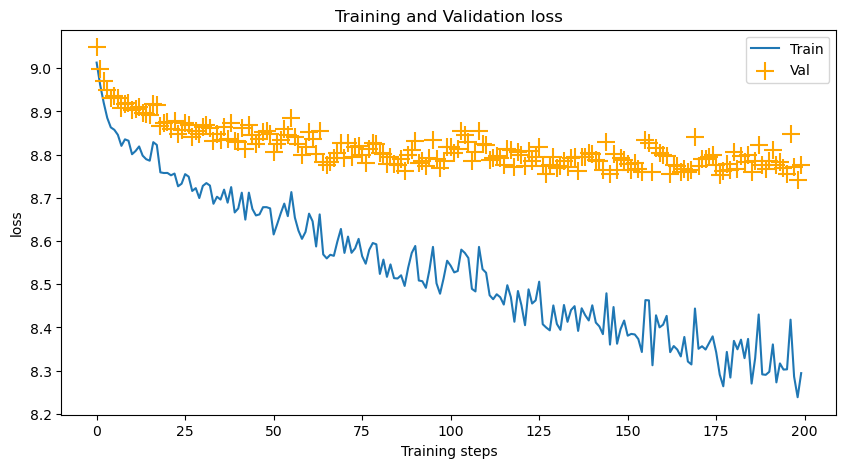

Train rmse: 8.294316291809082
Val rmse: 8.775754928588867
best val rmse: 8.74065113067627


In [23]:
set_random_seed(123)
# на трейне значения выше из-за dropout. На тесте от отключается
train(model3, EPOCHS, optimizer, criterion, train_dataloader_target, test_dataloader_target)
# 9: 003    8:9634 

In [24]:
assert test(model3, criterion, test_dataloader_target).shape[0] == y_test.shape[0]

In [25]:
best_model_regressor = Net2().to(device)
best_model_regressor.load_state_dict(torch.load("best_weights1", weights_only=True))

<All keys matched successfully>

In [26]:
rmse = inversed_rmse(test(best_model_regressor, criterion, test_dataloader_target),
                     torch.Tensor(test_dataloader_target.dataset.tensors[1]).to(device), scaler_target)
rmse

8.74065113067627

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Моделей и запусков было конечно больше, но ключевых моделей, изменивших весь ход выполнения домашнего задания, было 9
# Первая модель - 9.384
Сначала я задался вопросом какой скалер использовать, и в одной статье прочитал, что для relu нужно использовать MinMaxScaler из-за того что его значения лежат в (0,1), который я успешно применил для первых экспериментах, но на них результаты были плохие (я их не сохранил), после чего для следующих моделей я начал использовать StandardScaler.
Первая модель имела архитекутру вида:
90-128-64-1
После каждого слоя был batchnorm, relu и dropout с 50-ти процентной вероятностью
Эта модель обучалась с помощью обучения, написанного вручную. Следующие модели обучались уже с помощью pytorch lighting (я не знал, можно ли использовать pytprch lighting, поэтому сначала сделал без него)
Модель обучалась с размером шага 0.001. Размер батча также, как и для всех моделей был 256
Также в качестве оптимайзера был использован Adam, добавляющий инерцию и масштабирование градиента
Шедулер я не стал использовать
Сначала эта модель быстро обучилась за 3 шага, но после этого очень медленно обучалась и я останавливал обучение где-то на 10-м шаге с отметкой 29. После этого я несколько дней пытался найти ошибки в коде, думая, что я как-то неправильно считаю loss, но всё оказалось намного проще. В какой-то момент я решил не останавливать эсперимент на 10 эпохах, а попробовать обучить сразу на 200-т, после чего RMSE уменьшилось с 29 на валидации до 9.384 к 200-му шагу, но этого всё равно было много

# не в счёт: Вторая модель - 8.89 😭
Эту модель я обучил уже использую pytoch lighting. Я решил сделать модель побольше, быстро переходящую к 1080 признак и затем медленно уменьшающуюся по степеням двойки от 1080 до 16. Затем от 16 модель переходила к 1 для регрессии. Итоговая модель имела вид:
90-1024-512-256-128-64-32-16-1
Эта модель также после каждого слоя имела batchnorm, relu и dropout с 50-ти процентной вероятность
Эта модель уже имела больший размер шага - 0.01, но его всё равно не хватало, чтобы обучить модель за 50 эпох, поэтому потребовалось ещё 150 дополнительных эпох, чтобы по итогу получить 8.89, чего едва хватало на 6 баллов.
Я понял, что модель ещё больше будет тяжело обучить с моей странной скоростью обучения, поэтому я опять несколько дней пытался найти ошибку в коде, из-за которой модель не хочет нормально обучаться. Перепробовав несколько вариантов скалеров я задался вопросом, нужно ли скалировать таргет. На большинстве сайтов говорилось, что в этом нет необходимости и ничего не поменяется, но на на одном из форумов не самый популярный ответ помог мне разобраться с этим вопросом - https://stats.stackexchange.com/a/391354
После этого я нашёл в api скалера метод inverse_transform и смог решить задачу

# не в счёт: Третья модель - 8.715 😭
Я сделал всё то же самое, что и во второй модели, только при этом отскалировал таргет, на валидация инвертируя его к исходным пропорциям. Это позволило добиться мне RMSE равного 8.715 на оценку 10
 
# не в счёт: Четвёртая модель - 8.69 😭
У меня сломался весь javascript в ноутбуке (сломался tqdm) и пришлось перезапустить все ячейки и удать старые попытки решить задачу. После этого я заметил, что модель достигает хорошего результата и затем то переобучается, то снова обучается, поэтому я решил добавить шедулер с уменьшающейся скоростью обучения каждые 10 эпох, начиная с шага 0.001.
Также, я добавил чекпойнты для лучших весов модели, которые позволяют сохранить лучшие веса до начала переобучения модели. Но эти чекпойнты не пригодились, так как один шедулер уже улучшил ситуацию

Инфу о лайтинге взял из семинаров
Информацию о шедулерах взял отсюда:
 https://lightning.ai/docs/pytorch/stable/common/optimization.html#bring-your-own-custom-learning-rate-schedulers
Использовал шедулер 
https://timm.fast.ai/stepLR 
Чекпойнты:
https://lightning.ai/docs/pytorch/stable/common/checkpointing_intermediate.html

Но я всё удалил...

# Пятая модель - 8.94 
Затем я перечитал задание и понял, что нельзя было использовать pytorch lighting, поэтому начинаю с начала)
Просто переписал train с lighting'а, но кажется по пути что-то сломал (ошибка стала такой же, как до скалирования таргета, возможно дело в этом)

# шестая модель - 9.11
В отчаяньи я решил усложнить модель и сделать жалкий аналог U-net с residual слоями вида 90-256-512-1024-2048-1024+1024-512+512-256+256-1 (где + это skip connections). Но увы, модель не обучилась нормально. Попробую перечитать функцию трейна ещё примерно 1000 раз, может поможет найти ошибку с инвертированием скалирования.

# седьмая модель - 8.85
Я немного поменял модель (добавил промежуточный полносвязный слой с 1024 на 2048) и увеличил шаг до 0.001 (скорее всего это и помогло, так как я вспомнил, что у модели из лайтинга как раз такой шаг и был, так что я попробую вернуть старую модель и поиграться с шагами)

# Восьмая модель - 9.05
Я попробовал отобрать первые 10-40 признаков
Менял размер модели, размеры шага, параметры шедулера, размеры батча
От этого становилось только хуже. 

# Девятая модель - 8.74
Я вернул старую модель, старые признаки, старый размер шага и просто убрал шедулер, который, видимо, не сработал у меня нормально вне lighting'a...
Модель имела такие линейные слои:
90-512-1024-512-256-128-64-1
Также использовалась функция активация selu, batchnorm и dropout
Для интереса попробовал ещё заморозить все слои и обучить новый, более сложный, классификатор, но качество стало только чуть хуже (поднялось до 8.76)


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

In [21]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer

# Скалирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Для первого варианта закодирую таргет с помощью label encoder'a
label_encoder = LabelEncoder()
y_train_classification_year = label_encoder.fit_transform(y_train.reshape(-1))
y_test_classification_year = label_encoder.transform(y_test.reshape(-1))

# Для второго закодирую по бинам
bin_encoder = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
y_train_classification_bin = bin_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_classification_bin = bin_encoder.transform(y_test.reshape(-1, 1))

In [22]:
len(np.unique(y_train_classification_year))

89

In [23]:
y_train_classification_bin

array([[8.],
       [8.],
       [8.],
       ...,
       [9.],
       [9.],
       [9.]])

In [80]:
# year
# Create datasets
train_dataset_with_year = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train_classification_year.reshape(-1, 1), dtype=torch.long)
)

test_dataset_with_year = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test_classification_year.reshape(-1, 1), dtype=torch.long)
)

# Create dataloaders
train_dataloader_year = DataLoader(train_dataset_with_year, batch_size=256, num_workers=0)
test_dataloader_year = DataLoader(test_dataset_with_year, batch_size=1024, num_workers=0, shuffle=False)

# bins
# Create datasets
train_dataset_with_bin = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train_classification_bin.reshape(-1, 1), dtype=torch.long)
)

test_dataset_with_bin = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test_classification_bin.reshape(-1, 1), dtype=torch.long)
)

# Create dataloaders
train_dataloader_bin = DataLoader(train_dataset_with_bin, batch_size=256, num_workers=0)
test_dataloader_bin = DataLoader(test_dataset_with_bin, batch_size=1024, num_workers=0, shuffle=False)

In [74]:
class Net_year(DefaultNet):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.SiLU()
        self.dropout = torch.nn.Dropout(p=0.5)

        self.batch_norm0 = torch.nn.BatchNorm1d(90)
        self.linear1 = torch.nn.Linear(in_features=90, out_features=512)
        self.batch_norm1 = torch.nn.BatchNorm1d(512)
        self.linear2 = torch.nn.Linear(in_features=512, out_features=1280)
        self.batch_norm2 = torch.nn.BatchNorm1d(1280)
        self.linear3 = torch.nn.Linear(in_features=1280, out_features=512)
        self.batch_norm3 = torch.nn.BatchNorm1d(512)
        self.linear4 = torch.nn.Linear(in_features=512, out_features=256)
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        self.linear5 = torch.nn.Linear(in_features=256, out_features=128)
        self.batch_norm5 = torch.nn.BatchNorm1d(128)
        self.output = torch.nn.Sequential(
            torch.nn.Linear(in_features=128, out_features=89),
            torch.nn.Softmax(dim=1)
        )

    def _forward(self, x):
        x = self.batch_norm0(x)
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear4(x)
        x = self.batch_norm4(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear5(x)
        x = self.batch_norm5(x)
        x = self.activation(x)
        x = self.dropout(x)

        return self.output(x)

In [75]:
class Net_bin(DefaultNet):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.SiLU()
        self.dropout = torch.nn.Dropout(p=0.5)

        self.batch_norm0 = torch.nn.BatchNorm1d(90)
        self.linear1 = torch.nn.Linear(in_features=90, out_features=512)
        self.batch_norm1 = torch.nn.BatchNorm1d(512)
        self.linear2 = torch.nn.Linear(in_features=512, out_features=1280)
        self.batch_norm2 = torch.nn.BatchNorm1d(1280)
        self.linear3 = torch.nn.Linear(in_features=1280, out_features=512)
        self.batch_norm3 = torch.nn.BatchNorm1d(512)
        self.linear4 = torch.nn.Linear(in_features=512, out_features=256)
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        self.linear5 = torch.nn.Linear(in_features=256, out_features=128)
        self.batch_norm5 = torch.nn.BatchNorm1d(128)
        self.output = torch.nn.Sequential(
            torch.nn.Linear(in_features=128, out_features=10),
            torch.nn.Softmax(dim=1)
        )

    def _forward(self, x):
        x = self.batch_norm0(x)
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear4(x)
        x = self.batch_norm4(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.linear5(x)
        x = self.batch_norm5(x)
        x = self.activation(x)
        x = self.dropout(x)

        return self.output(x)

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score 


def train(model, n_epochs, optimizer, criterion, train_loader, test_loader, attempt="1", device=device):
    """
    fit
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    train_accuracy_log, train_precision_log, train_recall_log, val_accuracy_log, val_precision_log, val_recall_log, = [], [], [], [float("-inf")], [float("-inf")], [float("-inf")]

    for epoch in range(n_epochs):
        # тренировка
        model.train()
        for x, target in tqdm(
                train_loader, desc=f"Training, epoch {epoch}", leave=False
        ):
            optimizer.zero_grad()
            x, target = x.to(device), target.to(device).squeeze()

            y_pred = model(x).to(device).squeeze()
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        model.eval()
        with torch.no_grad():

            # train
            y_pred = torch.argmax(model(torch.Tensor(train_loader.dataset.tensors[0]).to(device)), dim=1)
            target = train_loader.dataset.tensors[1]

            
            train_accurracy = accuracy_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
            train_precision = precision_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='weighted', zero_division=0)
            train_recall = recall_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='weighted')
            
            train_accuracy_log.append(train_accurracy)
            train_precision_log.append(train_precision)
            train_recall_log.append(train_recall)

            # val
            y_pred = torch.argmax(model(torch.Tensor(test_loader.dataset.tensors[0]).to(device)), dim=1)
            target = test_loader.dataset.tensors[1]

            
            val_accurracy = accuracy_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
            val_precision = precision_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='weighted', zero_division=0)
            val_recall = recall_score(target.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='weighted')
            
            if val_accurracy > max(val_accuracy_log):  # save best weights
                torch.save(model.state_dict(), "best_weights" + attempt)
            
            val_accuracy_log.append(val_accurracy)
            val_precision_log.append(val_precision)
            val_recall_log.append(val_recall)

        clear_output(wait=True)
        plot_history(train_accuracy_log, val_accuracy_log, "loss")
        
        print("Train accuracy:", train_accuracy_log[-1])
        print("Train precision:", train_precision_log[-1])
        print("Train recall:", train_recall_log[-1])
        
        print("Val accuracy:", val_accuracy_log[-1])
        print("Val precision:", val_precision_log[-1])
        print("Val recall:", val_recall_log[-1])
        
        print("Best val accuracy:", max(val_accuracy_log))
        print("Best val precision:", max(val_precision_log))
        print("Best val recall:", max(val_recall_log))

Сделаю также 120 эпох

In [56]:
EPOCHS = 120
LR = 0.001

In [57]:
set_random_seed(123)
model_ans = Net_year().to(device)
optimizer = torch.optim.Adam(model_ans.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()


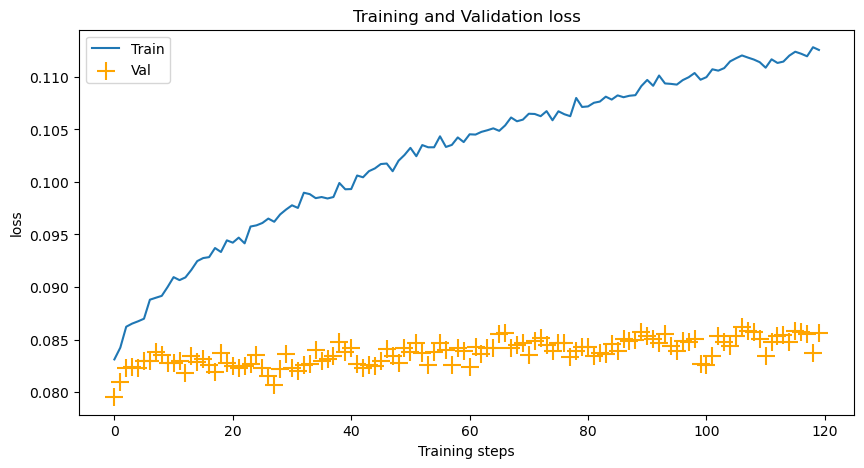

Train accuracy: 0.11256482969065051
Train precision: 0.05147590209946477
Train recall: 0.11256482969065051
Val accuracy: 0.08566724772419136
Val precision: 0.03742363209933008
Val recall: 0.08566724772419136
Best val accuracy: 0.08620956808057331
Best val precision: 0.09396430606886848
Best val recall: 0.08620956808057331


In [58]:
# на трейне значения выше из-за dropout. На тесте от отключается
set_random_seed(123)
train(model_ans, EPOCHS, optimizer, criterion, train_dataloader_year, test_dataloader_year, attempt="2")

In [60]:
best_model_classifier_year = Net_year().to(device)
best_model_classifier_year.load_state_dict(torch.load("best_weights2", weights_only=True))

<All keys matched successfully>

In [66]:
assert test(best_model_classifier_year, criterion, test_dataloader_year).shape[0] == y_test.shape[0]

In [67]:
y_pred = torch.argmax(test(best_model_classifier_year, criterion, test_dataloader_year), dim=1)

print("accurracy =",accuracy_score(torch.Tensor(test_dataloader_year.dataset.tensors[1]).cpu().detach().numpy(), y_pred.cpu().detach().numpy()))
print("precision =",precision_score(torch.Tensor(test_dataloader_year.dataset.tensors[1]).cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='weighted', zero_division=0))
print("recall =",recall_score(torch.Tensor(test_dataloader_year.dataset.tensors[1]).cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='weighted'))

accurracy = 0.08620956808057331
precision = 0.03652193631089768
recall = 0.08620956808057331


In [76]:
set_random_seed(123)
model_bin = Net_bin().to(device)
optimizer = torch.optim.Adam(model_bin.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

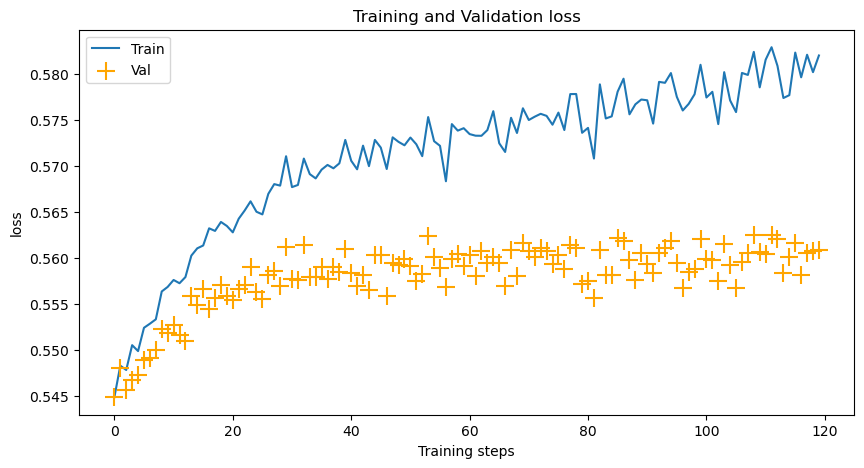

Train accuracy: 0.5820557885770354
Train precision: 0.511185521892364
Train recall: 0.5820557885770354
Val accuracy: 0.5608367228355607
Val precision: 0.4948944962379535
Val recall: 0.5608367228355607
Best val accuracy: 0.5625605268254891
Best val precision: 0.5103222940888736
Best val recall: 0.5625605268254891


In [79]:
# на трейне значения выше из-за dropout. На тесте от отключается
set_random_seed(123)
train(model_bin, EPOCHS, optimizer, criterion, train_dataloader_bin, test_dataloader_bin, attempt="3")

In [81]:
best_model_classifier_bin = Net_bin().to(device)
best_model_classifier_bin.load_state_dict(torch.load("best_weights3", weights_only=True))

<All keys matched successfully>

In [83]:
assert test(best_model_classifier_bin, criterion, test_dataloader_bin).shape[0] == y_test.shape[0]

In [82]:
y_pred = torch.argmax(test(best_model_classifier_bin, criterion, test_dataloader_bin), dim=1)

print("accurracy =",accuracy_score(torch.Tensor(test_dataloader_bin.dataset.tensors[1]).cpu().detach().numpy(), y_pred.cpu().detach().numpy()))
print("precision =",precision_score(torch.Tensor(test_dataloader_bin.dataset.tensors[1]).cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='weighted', zero_division=0))
print("recall =",recall_score(torch.Tensor(test_dataloader_bin.dataset.tensors[1]).cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='weighted'))

accurracy = 0.5625605268254891
precision = 0.4905273069819578
recall = 0.5625605268254891


> Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

Полученные модели получились не самые лучшие, скорее всего сами данные слабо отражают информацию о годе выпуска музыки. К тому же классы довольно похожи, особенно для разделения по годам. Для бинов точность тоже получилась не самая лучшая, но точно лучше чем у индивидуальных годов, что может свидетельствовать о разделимости данных по десятилетиям (или просто о том, что классов стало меньше). Проблема явно не в самом количестве классов, так как современные нейронный сети могут с точностью более 95% классифицировать изображения с сотней классов (у cifar100 сейчас 96%), что явно говорит о недостатки самих данных. Кроме того, моя модель тоже не самая лучшая, но разбираться с cnn или трансформерами для табличных данных в первом домашнем задании я думаю будет избыточно (да и не хватит данных для обучения трансформеров). В общем всё плохо: плохие данные, плохая модели, плохая точность....

Для изменения задачи с регрессии на классификацию я проделал следующие шаги:
1. Убрал скалирование по таргету, но добавил label encoder для кодирования по годам и KBinsDiscretizer для кодирования по бинам
2. Заменил выход нейронных сетей на классификатор с большим количеством выходных слоёв (их количество соответствует количеству классов) и добавил SoftMax для того, чтобы вероятности в сумме давали 1. Также я немного поменял количество промежуточных линейных слоёв с 1080 до 1080+256. На самом деле SoftMax можно было не делать, ведь после него я использовал ArgMax, который оставляет только один класс с наибольшим значением, а остальные зануляет. SoftMax же лучше использовать в ситуации Multi-label, а не Multi-class
3. В трейне, на этапе валидации, я заменил подсчёт rmse со сложным вычислением инвертированного скалера на стандартные метрики из sklearn (precision, recall, accuracy)
4. На этапе запуска обучения я только поменял лосс функцию на CrossEntropy (функция для классификации)